In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import pmdarima as pm

/var/folders/bt/nlh_3ptx6znf2gx6qszlwdxm0000gn/T/ipykernel_1222/3169776344.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv("../Data/RawTrafficData.csv", index_col=0)
df.index = pd.to_datetime(df.index)
matplotlib.rcParams.update({'font.size': 14})

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45887D-01    |proj g|=  1.44741D+00

At iterate    5    f=  3.78234D-01    |proj g|=  6.04583D-01

At iterate   10    f=  3.75497D-01    |proj g|=  1.27613D+00

At iterate   15    f=  3.75166D-01    |proj g|=  2.95402D+00

At iterate   20    f=  3.72175D-01    |proj g|=  8.73791D-01

At iterate   25    f=  3.69115D-01    |proj g|=  1.94657D+00

At iterate   30    f=  3.68641D-01    |proj g|=  1.60960D-01

At iterate   35    f=  3.63929D-01    |proj g|=  6.79760D+00

At iterate   40    f=  3.58234D-01    |proj g|=  9.66456D-02

At iterate   45    f=  3.57282D-01    |proj g|=  1.05694D-01

At iterate   50    f=  3.54566D-01    |proj g|=  7.77792D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


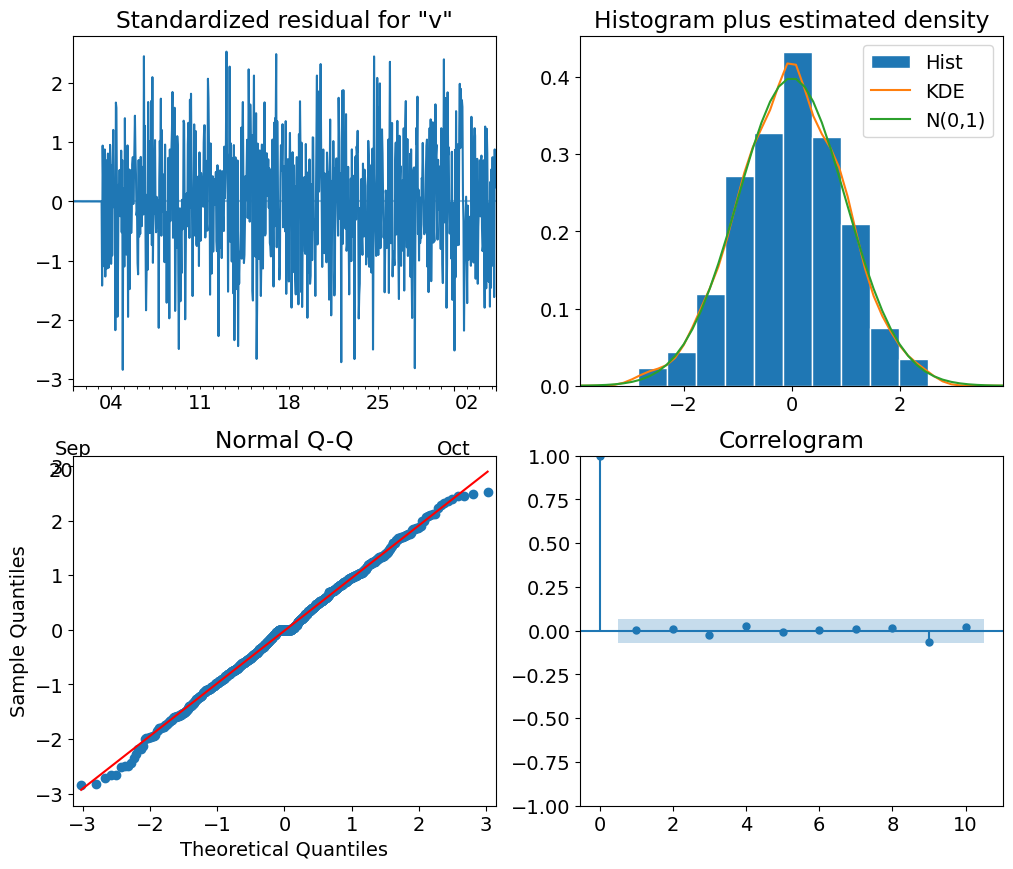

In [4]:
train = df.value[:800] # All models are trained on the first 800 instances (online learning is only evaluated after instance nr 800 to have fair comparison)
test = df.value[801:]

p, d, q = 6, 0, 6
P, D, Q, s = 2, 1, 2, 24 

sarima_model = sm.tsa.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), initialization='approximate_diffuse')
results = sarima_model.fit()

results.plot_diagnostics(figsize=(12,10))
plt.show()


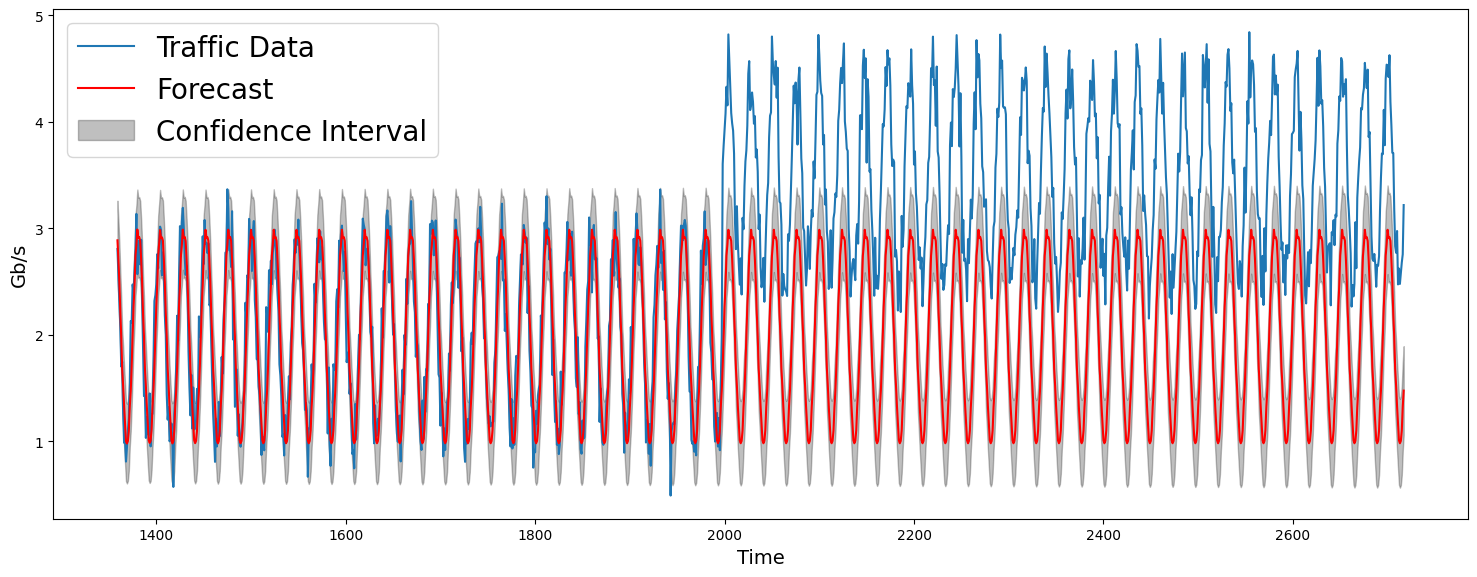

In [5]:
forecast_steps = len(test)  
forecast = results.get_forecast(steps=forecast_steps)

forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int(alpha=0.05)


forecast_index = range(len(test), len(test) + len(forecast_values))

fig, axs = plt.subplots(1, 1, figsize=(15, 6))

axs.plot(forecast_index,test, label='Traffic Data')
axs.plot(forecast_index, forecast_values, label='Forecast', color="red")


axs.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],  # Lower bound of CI
                 confidence_intervals.iloc[:, 1],  # Upper bound of CI
                 color='k', alpha=.25, label="Confidence Interval")

axs.legend(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Gb/s')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('./GeneratedPlots/ARIMAForecast.png') 
plt.show()

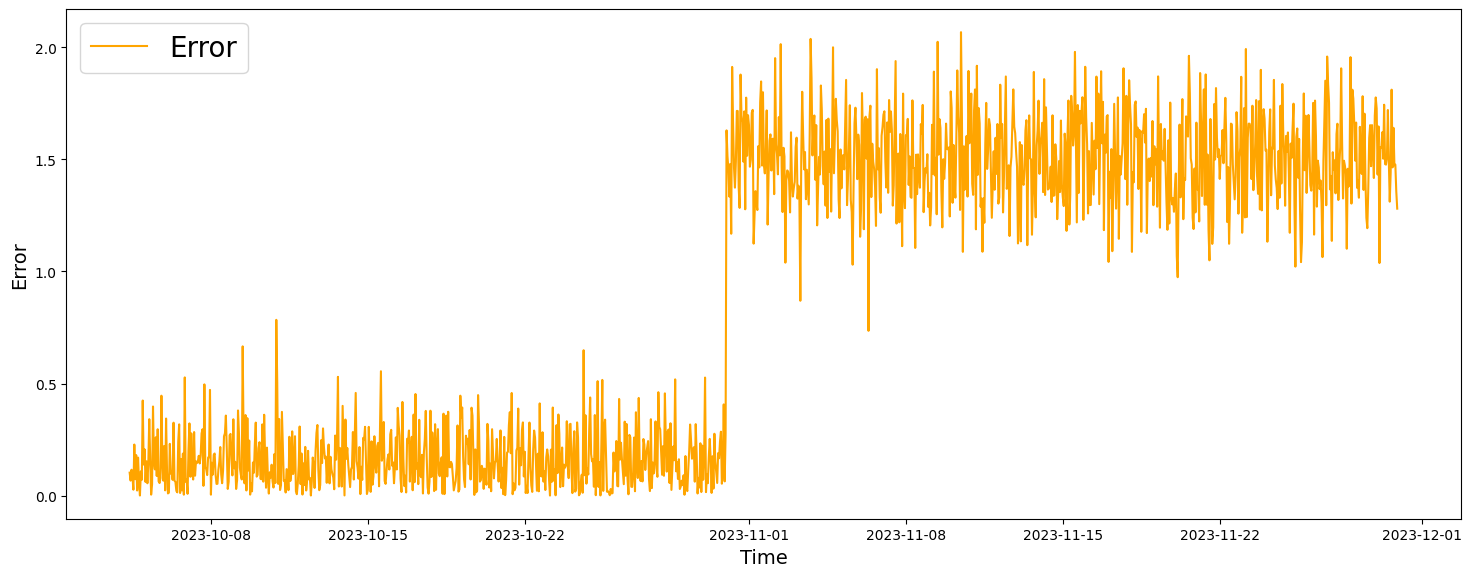

In [10]:
errors = np.abs(test-forecast_values)

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.plot(errors, label = "Error", color="orange")
axs.legend(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Error')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('./GeneratedPlots/ARIMAForecastError.png') 
plt.show()

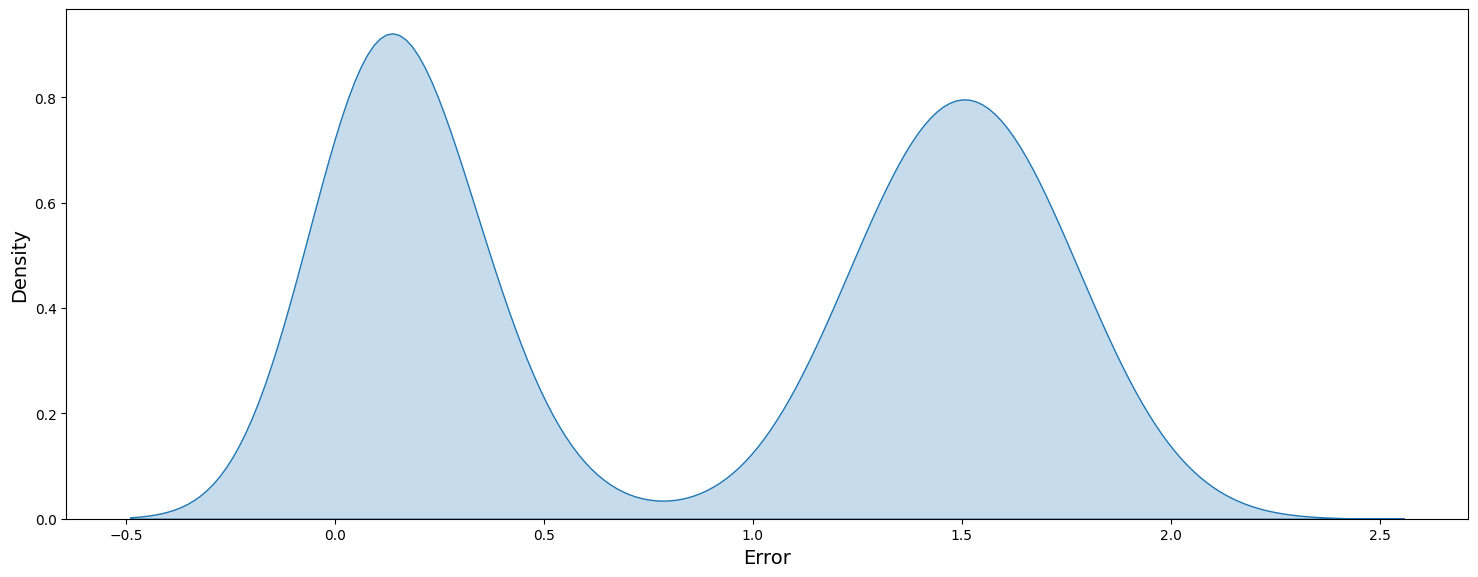

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
sns.kdeplot(errors, ax=axs, fill=True)
axs.set_xlabel('Error')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('./GeneratedPlots/ARIMAErrorDistribution.png')  
plt.show()   

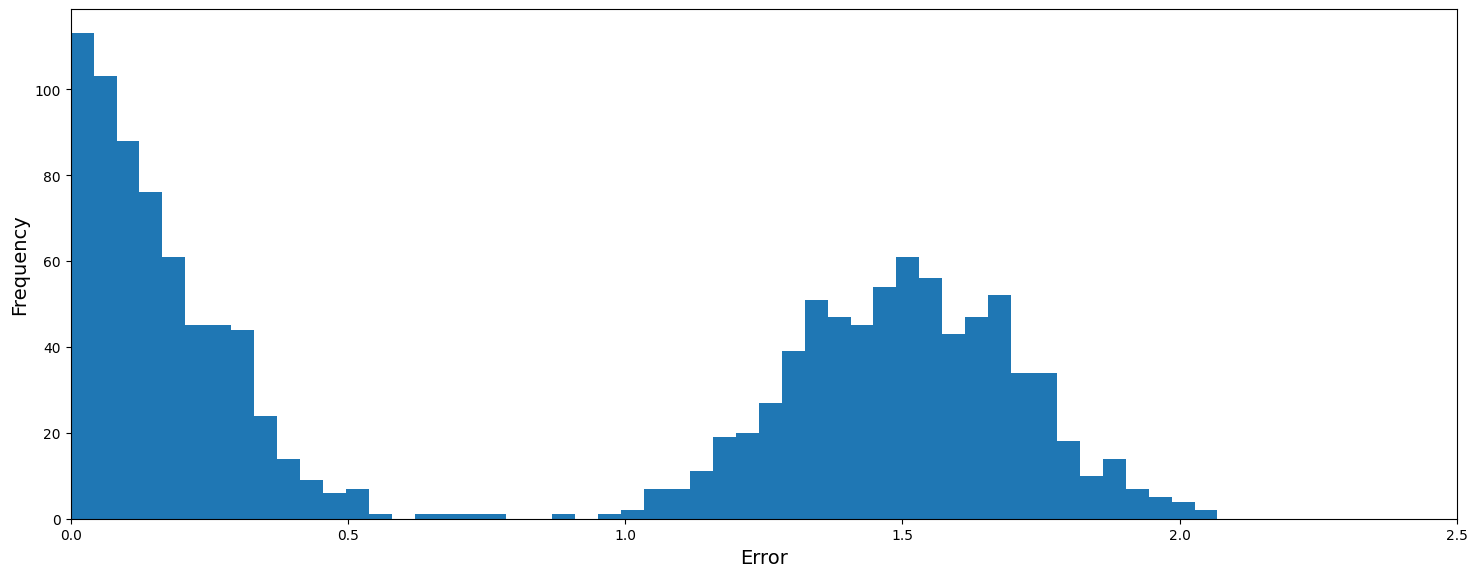

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))

plt.hist(errors, bins=50)
axs.set_xlim(0, 2.5)
plt.ylabel('Frequency')
plt.xlabel('Error')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('./GeneratedPlots/ARIMAErrorDistributionHist.png') 
plt.show()   

# Anomaly Detection using ARIMA and Confidence Interval

In [19]:
base_series = df.value
time = np.arange(0, len(base_series), 1) 
start_index = math.floor((1/2)*len(df.value))

proportion_anomalies = 0.007
num_anomalies = int((len(time) - start_index) * proportion_anomalies) # this will be mutltiplied with 2 since there will be upwards and downwards point anomalies

anomalous_series = base_series.copy()

#Positive Point Anomalies
p_anomaly_indices = np.random.choice(range(start_index, len(time)), num_anomalies, replace=False)
anomaly_amplitudes = np.random.uniform(0.7, 2.0, num_anomalies)

anomalous_series.iloc[p_anomaly_indices] += anomaly_amplitudes

#Negative Point Anomlaies
n_anomaly_indices = np.random.choice(range(start_index, len(time)), num_anomalies, replace=False)
anomaly_amplitudes = np.random.uniform(-2.0, -0.7, num_anomalies)

anomalous_series.iloc[n_anomaly_indices] += anomaly_amplitudes

anomaly_indices = np.append(p_anomaly_indices, n_anomaly_indices)
    
df['Anomalie_Data'] = anomalous_series
df['Anomalous'] = 0
df.iloc[anomaly_indices, df.columns.get_loc('Anomalous')] = 1

drift_index = math.floor((2/3)*len(anomalous_series))
df.iloc[drift_index, df.columns.get_loc('Anomalous')] = 1

In [20]:
df.head()

,value,Anomalie_Data,Anomalous
2023-09-01 00:00:00,1.825067,1.825067,0
2023-09-01 01:00:00,2.121939,2.121939,0
2023-09-01 02:00:00,2.357743,2.357743,0
2023-09-01 03:00:00,2.932698,2.932698,0
2023-09-01 04:00:00,2.886991,2.886991,0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45887D-01    |proj g|=  1.44741D+00


 This problem is unconstrained.



At iterate    5    f=  3.78234D-01    |proj g|=  6.04583D-01

At iterate   10    f=  3.75497D-01    |proj g|=  1.27613D+00

At iterate   15    f=  3.75166D-01    |proj g|=  2.95402D+00

At iterate   20    f=  3.72175D-01    |proj g|=  8.73791D-01

At iterate   25    f=  3.69115D-01    |proj g|=  1.94657D+00

At iterate   30    f=  3.68641D-01    |proj g|=  1.60960D-01

At iterate   35    f=  3.63929D-01    |proj g|=  6.79760D+00

At iterate   40    f=  3.58234D-01    |proj g|=  9.66456D-02

At iterate   45    f=  3.57282D-01    |proj g|=  1.05694D-01


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.54566D-01    |proj g|=  7.77792D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     68      1     0     0   7.778D-01   3.546D-01
  F =  0.35456560087313704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


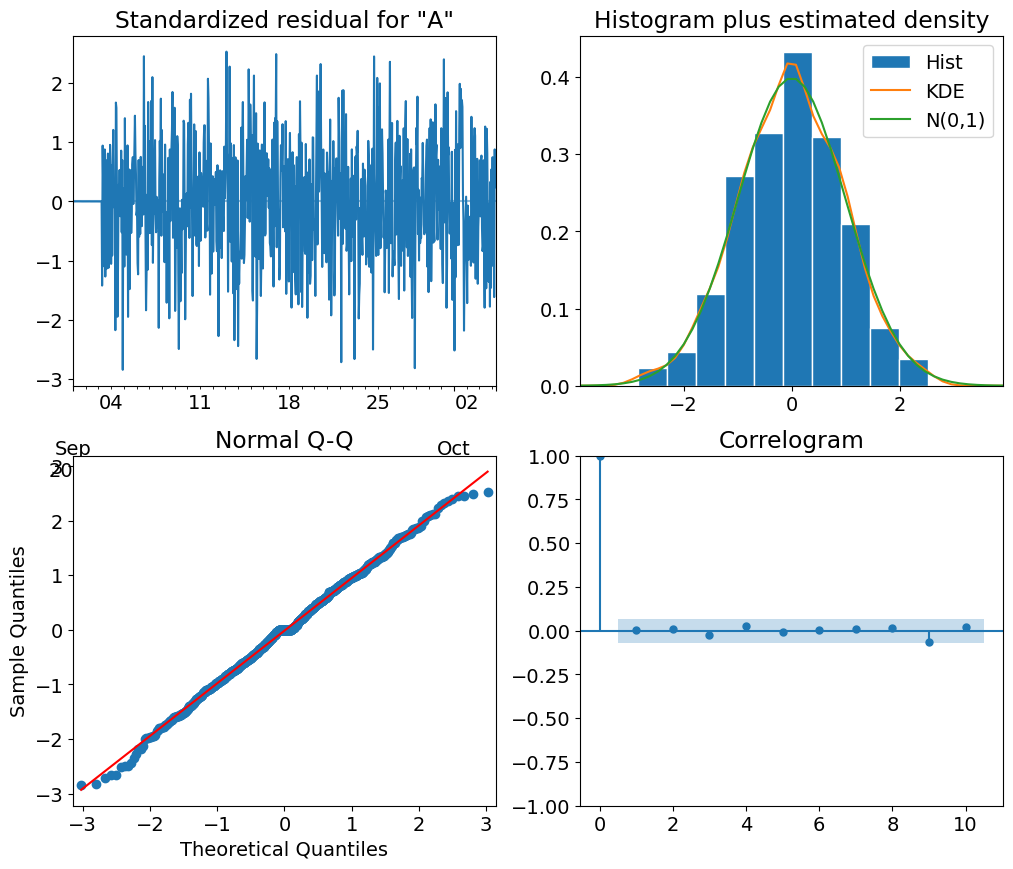

In [21]:
train = df.Anomalie_Data[:800] # All models are trained on the first 800 instances (online learning is only evaluated after instance nr 800 to have fair comparison)
test = df.Anomalie_Data[801:]

p, d, q = 6, 0, 6
P, D, Q, s = 2, 1, 2, 24 

sarima_model = sm.tsa.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), initialization='approximate_diffuse')
results = sarima_model.fit()

results.plot_diagnostics(figsize=(12,10))
plt.show()

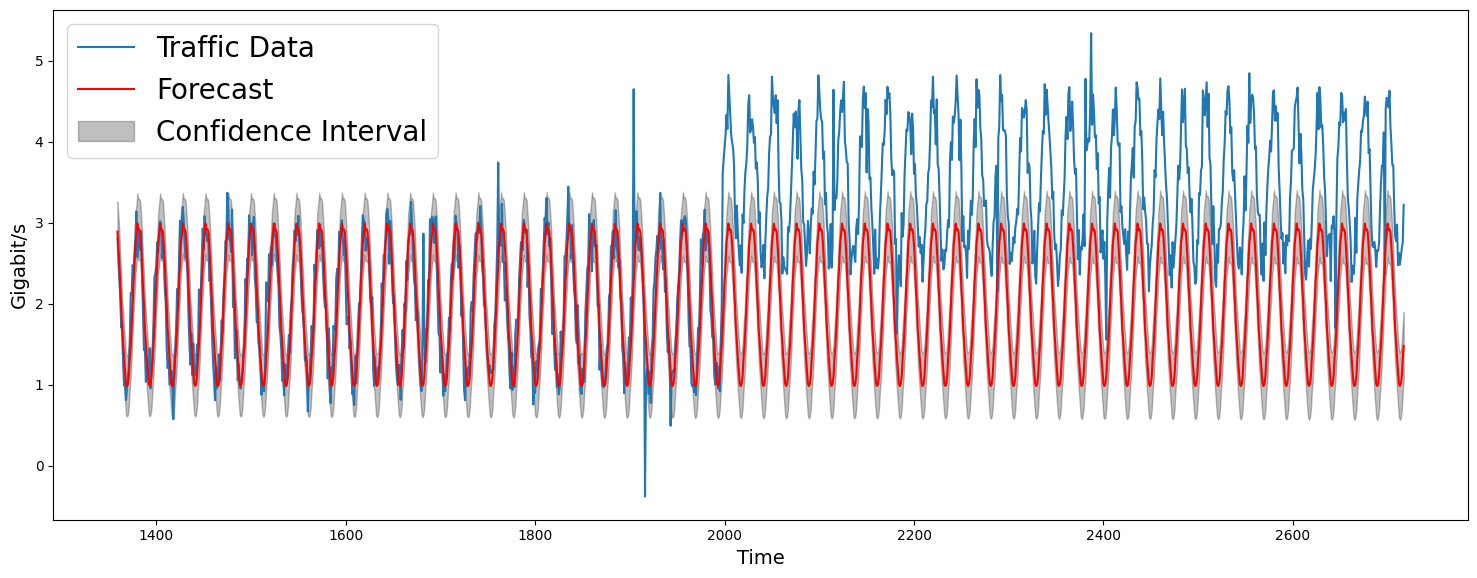

In [54]:
forecast_steps = len(test)  
forecast = results.get_forecast(steps=forecast_steps)

forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int(alpha=0.05)


forecast_index = range(len(test), len(test) + len(forecast_values))

fig, axs = plt.subplots(1, 1, figsize=(15, 6))

axs.plot(forecast_index,test, label='Traffic Data')
axs.plot(forecast_index, forecast_values, label='Forecast',color="red")


axs.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],  # Lower bound of CI
                 confidence_intervals.iloc[:, 1],  # Upper bound of CI
                 color='k', alpha=.25, label="Confidence Interval")

axs.legend(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Gigabit/s')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('./GeneratedPlots/ARIMAForecast.png') 
plt.show()

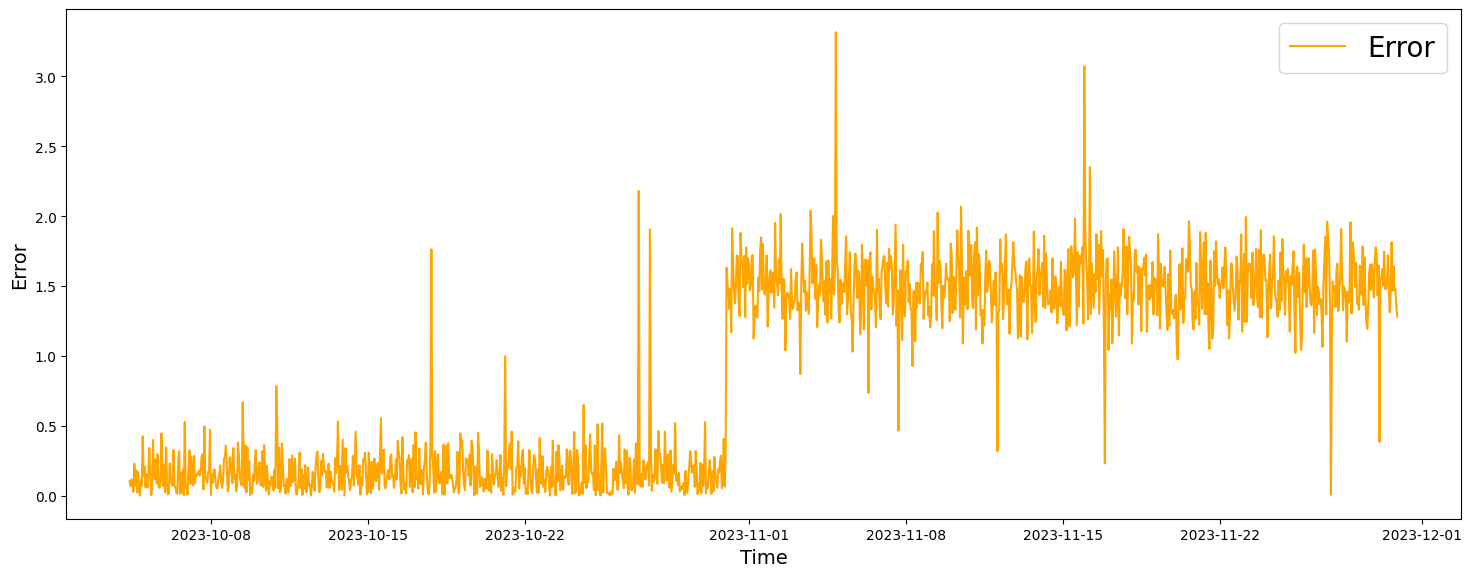

In [24]:
errors = np.abs(test-forecast_values)

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.plot(errors, label = "Error", color="orange")
axs.legend(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Error')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('./GeneratedPlots/ARIMAForecastError.png') 
plt.show()

In [25]:
import numpy as np

ground_truth_values = test
anomaly_scores = np.zeros(len(ground_truth_values))

for i, true_value in enumerate(ground_truth_values):
    lower_bound = confidence_intervals.iloc[i, 0] 
    upper_bound = confidence_intervals.iloc[i, 1] 
    prediction = (lower_bound + upper_bound) / 2
    
    threshold = np.abs(prediction-upper_bound) * 6
    error = np.abs(true_value - prediction)

    if error >= threshold:
        anomaly_scores[i] = 1.0
    else:
        anomaly_scores[i] = error / threshold

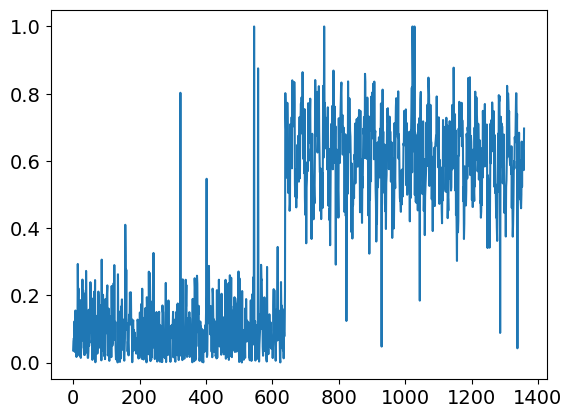

In [26]:
plt.plot(anomaly_scores)

In [34]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
anomaly_scores = np.array(anomaly_scores)  
true_labels = np.array(df.Anomalous[801:]) 

thresholds = np.arange(0.0, 1.01, 0.01) 
max_f1 = 0
optimal_threshold = 0

for threshold in thresholds:
    predicted_labels = np.where(anomaly_scores >= threshold, 1, 0)
    f1 = f1_score(true_labels, predicted_labels)

    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = threshold

print(optimal_threshold)
predicted_labels = np.where(anomaly_scores >= optimal_threshold, 1, 0)

accuracy = accuracy_score(true_labels, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")

0.87
Accuracy: 0.9911699779249448
TP: 5, FP: 2, TN: 1342, FN: 10
Recall: 0.3333333333333333, Precision: 0.7142857142857143, F1 Score: 0.45454545454545453


# Just score everything before the ConceptDrift and after

In [53]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

anomaly_scores = np.array(anomaly_scores)  
true_labels = np.array(df.Anomalous[801:]) 

CD_index = 640

anomaly_scores_BCD  = anomaly_scores[:CD_index]
true_labels_BCD  = true_labels[:CD_index]

true_labels_ACD  = true_labels[CD_index+1:]
anomaly_scores_ACD  = anomaly_scores[CD_index+1:]

# Before CD

thresholds = np.arange(0.0, 1.01, 0.01) 
max_f1 = 0
optimal_threshold = 0

for threshold in thresholds:
    predicted_labels = np.where(anomaly_scores_BCD >= threshold, 1, 0)
    f1 = f1_score(true_labels_BCD, predicted_labels)

    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = threshold

optimal_pre_concept_drift = optimal_threshold
predicted_labels = np.where(anomaly_scores_BCD >= optimal_threshold, 1, 0)

accuracy = accuracy_score(true_labels_BCD, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels_BCD, predicted_labels).ravel()

recall = recall_score(true_labels_BCD, predicted_labels)
precision = precision_score(true_labels_BCD, predicted_labels)
f1 = f1_score(true_labels_BCD, predicted_labels)

print("Before CD")
print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")



# After CD


thresholds = np.arange(0.0, 1.01, 0.01) 
max_f1 = 0
optimal_threshold = 0

for threshold in thresholds:
    predicted_labels = np.where(anomaly_scores_ACD >= threshold, 1, 0)
    f1 = f1_score(true_labels_ACD, predicted_labels)

    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = threshold
        
predicted_labels = np.where(anomaly_scores_ACD >= optimal_threshold, 1, 0)

accuracy = accuracy_score(true_labels_ACD, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels_ACD, predicted_labels).ravel()

recall = recall_score(true_labels_ACD, predicted_labels)
precision = precision_score(true_labels_ACD, predicted_labels)
f1 = f1_score(true_labels_ACD, predicted_labels)

print("After CD")
print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")


# After CD using same threshold as before CD

predicted_labels = np.where(anomaly_scores_ACD >= optimal_pre_concept_drift, 1, 0)

accuracy = accuracy_score(true_labels_ACD, predicted_labels)
tn, fp, fn, tp = confusion_matrix(true_labels_ACD, predicted_labels).ravel()

recall = recall_score(true_labels_ACD, predicted_labels)
precision = precision_score(true_labels_ACD, predicted_labels)
f1 = f1_score(true_labels_ACD, predicted_labels)

print("After CD using threshold from before CD")
print(f"Accuracy: {accuracy}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Recall: {recall}, Precision: {precision}, F1 Score: {f1}")

Before CD
Accuracy: 0.9984375
TP: 5, FP: 0, TN: 634, FN: 1
Recall: 0.8333333333333334, Precision: 1.0, F1 Score: 0.9090909090909091
Before CD
Accuracy: 0.9916434540389972
TP: 3, FP: 0, TN: 709, FN: 6
Recall: 0.3333333333333333, Precision: 1.0, F1 Score: 0.5
Before CD using threshold from before CD
Accuracy: 0.04317548746518106
TP: 3, FP: 681, TN: 28, FN: 6
Recall: 0.3333333333333333, Precision: 0.0043859649122807015, F1 Score: 0.008658008658008658
